# Pyomo.DoE: Optimization

Our [earlier exploratory analysis](./doe_exploratory_analysis.ipynb) showed the sine wave experiment alone is rank deficient. What if instead of optimizing the sine wave parameters $a$ and $p$, we directly optimize $u(t)$. In other words, we will formulate model-based design of experiments as an [optimal control problem](./pyomo_simulation.ipynb).

Maximize a scalar-valued function $\psi(\cdot)$ of the Fisher information matrix $\mathbf{M}$:

$$
\begin{align*}
\max_{u} \quad & \psi(\mathbf{M}) \\
\mathrm{s.t.} \quad & C_p^H \frac{dT_H}{dt} = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + \alpha P u(t)\\
& C_p^S \frac{dT_S}{dt} = - U_b (T_S - T_H)  \\
& 0\% \leq u(t) \leq 100 \% \\
& T_H(t_0) = T_{amb} \\
& T_S(t_0) = T_{amb}
\end{align*}
$$

`Pyomo.DoE` automatically formulates, initializes, and solves this optimization problem for $\psi(\cdot) = \log_{10}(\mathrm{trace}(\cdot))$, i.e., A-optimality, and $\psi(\cdot) = \log_{10}(\mathrm{det}(\cdot))$, i.e., D-optimality.

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TCLabExperiment,
    create_model,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load experimental data (sine test)

We will load the sine test data to serve as an initial point. Recall our create model function will use supplied data to initialize the Pyomo model. Carefully initialization is often required for optimization of large-scale dynamic systems.

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test.csv"
else:
    file = '../data/tclab_sine_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


For completeness, we will visualize the data again.

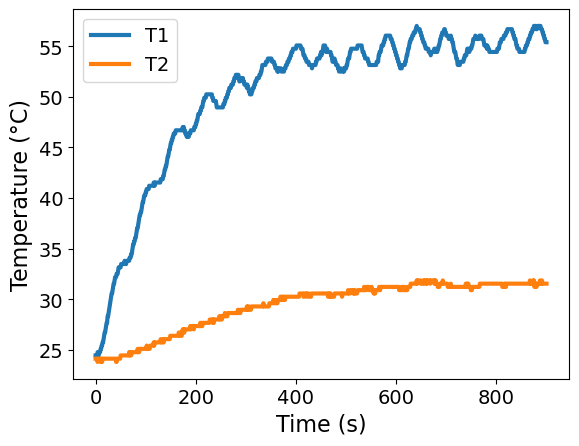

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

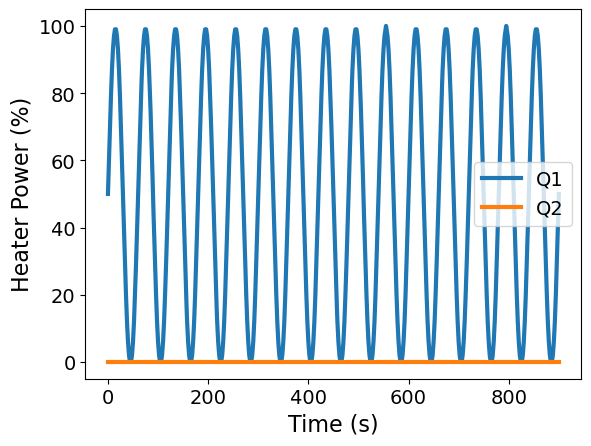

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

And then we will store the data in an instance of our `TCLabExperiment` dataclass.

In [5]:
tc_data = TCLabExperiment(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

## Calculate FIM at initial point (sine test)

We will start computing the FIM of the sine test experiment.

In [6]:
# Load Pyomo.DoE functions
from pyomo.contrib.doe import (
    ModelOptionLib,
    DesignOfExperiments,
    MeasurementVariables,
    DesignVariables,
)

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {
    'Ua': 0.05147278733764012,
    'Ub': 0.0005342082856927798,
    'inv_CpH': 0.14622879403418604,
    'inv_CpS': 99.99999754623846,
}

As before in our [explorator analysis](./doe_exploratory_analysis.ipynb), we need to specify the measurement variables.

In [7]:
# Get time points for control decisions
t_control = tc_data.time

measurements = MeasurementVariables()
measurements.add_variables('Ts1', indices={0: t_control}, time_index_position=0)

We also need to specify the decision variables. Notice in our [exploratory analysis](./doe_exploratory_analysis.ipynb), our decision variables were the sine wave parameters $a$ and $p$. Now we are defining the decision variables as the heater power directly. In other words, we do not need to specify a form for the control signal, which is more general. On the flip side, the optimization problem goes from two variables in [exploratory analysis](./doe_exploratory_analysis.ipynb) (period and amplitude) to 900 variables because our model considers 900 timesteps. But do not worry; Pyomo excels at optimization.

In [8]:
decisions = DesignVariables()

decisions.add_variables(
    'U1',
    indices={0: t_control},
    time_index_position=0,
    lower_bounds=0,
    upper_bounds=100,
    values=tc_data.u1,
)

In [9]:
def create_model_doe(theta=theta_values):
    return create_model(
        data=tc_data,
        mode='doe',
        theta=theta,
        integrate_to_initialize=True,
        number_of_states=number_tclab_states,
    )

We are now ready to construct a `DesignOfExperiments` object and compute the FIM.

In [10]:
# Create doe_object using DesignOfExperiments
doe_object1 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=SolverFactory('ipopt'),
)

result = doe_object1.compute_FIM(mode='sequential_finite', formula='central')
result.result_analysis()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:   111616
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    39626
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    23408
                     variables with only upper bounds:        0
Total number of equality constraints.................:    39626
Total number of ineq

Finally, we will look at the eigendecomposition using the helper function `results_summary` defined in `tclab_pyomo.py`.

In [11]:
results_summary(result)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.698903678286175
D-optimality: nan
E-optimality: nan
Modified E-optimality: nan

FIM:
 [[ 1.88459415e+08 -1.91393890e+08 -8.24201918e+06 -1.04121590e+03]
 [-1.91393890e+08  4.80931030e+09  6.51658566e+07  2.58102008e+04]
 [-8.24201918e+06  6.51658566e+07  1.46673544e+06  3.51179540e+02]
 [-1.04121590e+03  2.58102008e+04  3.51179540e+02  1.38519624e-01]]

eigenvalues:
 [ 4.81811358e+09  1.80716021e+08  4.06846518e+05 -2.41067013e-16]

eigenvectors:
 [[ 4.13259139e-02 -9.98655750e-01  3.12867703e-02 -1.00570603e-13]
 [-9.99053330e-01 -4.17276557e-02 -1.22982147e-02 -5.33299017e-06]
 [-1.35872064e-02  3.07489171e-02  9.99434786e-01 -2.48897567e-06]
 [-5.36175981e-06 -1.45999972e-07  2.42198261e-06  1.00000000e+00]]


/Users/adowling/DowlingLab/pyomo-doe/notebooks/tclab_pyomo.py:640: RuntimeWarning: invalid value encountered in log10
  print("D-optimality:", np.log10(result.det))
/Users/adowling/DowlingLab/pyomo-doe/notebooks/tclab_pyomo.py:641: RuntimeWarning: invalid value encountered in log10
  print("E-optimality:", np.log10(result.min_eig))
/Users/adowling/DowlingLab/pyomo-doe/notebooks/tclab_pyomo.py:642: RuntimeWarning: invalid value encountered in log10
  print("Modified E-optimality:", np.log10(result.cond))


## Optimize next experiment (D-optimality)

We are now ready to solve the optimization problem! Notice we create a new `DesignOfExperiments` object and specify the `prior_FIM` as result for the sine wave test. Thus we are decided what is the next best experiment to conduct. We already completed to sine test; we should use the data!

Some of the solver options below are commented out. These options are helpful for debugging the optimization problem. Likewise, relaxing the `tol` and `acceptable_tol` helps speed up sensitivity analyses where we resolve the optimization problem many times. We left these options commented out as a quick reference.

In [12]:
# Extract the prior FIM and Jacobian information from the previous
# result to use for initialization.
prior = result.FIM.copy()
jac_for_initialization = result.jaco_information.copy()

# Set Ipopt options
solver = SolverFactory('ipopt')
# solver.options['bound_push'] = 1E-10
solver.options['halt_on_ampl_error'] = 'yes'
# solver.options['tol'] = 1E-5
# solver.options['acceptable_tol'] = 1E-4
# solver.options['max_iter'] = 100
solver.options['linear_solver'] = 'ma57'

# Create a new DoE object
doe_object2 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=solver,
    prior_FIM=prior,  # use previous experiment as prior
)

# Solve the DoE problem
square_result2, optimize_result2 = doe_object2.stochastic_program(
    if_optimize=True,  # optimize
    if_Cholesky=True,  # use Cholesky decomposition
    scale_nominal_param_value=True,  # scale model parameter value
    objective_option="det",  # objective option (need to debug/improve initialization)
    jac_initial=jac_for_initialization,  # initialize Jacobian with prior solution
    step=0.01,  # step size
)

Ipopt 3.13.2: halt_on_ampl_error=yes
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:   136846
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9010

Total number of variables............................:    43240
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    23408
                     variables with only upper bounds:        0
Total number of equality constraints......

Now let's visualize the optimal experiment.

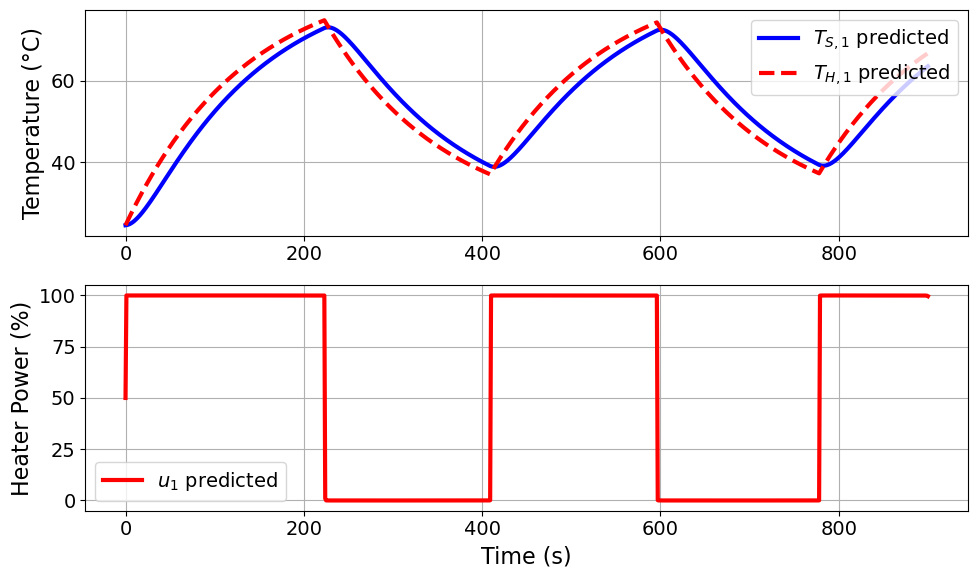

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
 


In [13]:
dopt_pyomo_doe_results = extract_plot_results(None, optimize_result2.model)

Fascinating. The D-optimal experiment is a square wave that fluctuates between maximum power and off. The square wave transitions from full power to off when the predicted sensor temperature reaches ~70 °C. Likewise, the heater turns back on when the sensor cools to ~40 °C.  This experiment captures two cooling cycles and almost three full heating events.

Finally, let's analyze the predicted FIM of the new optimized experiment plus the exisiting sine wave experiment.

In [14]:
optimize_result2.result_analysis()
results_summary(optimize_result2)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.698976151506269
D-optimality: 27.677646709938845
E-optimality: 4.002309075481948
Modified E-optimality: 5.6805691372959775

FIM:
 [[ 1.89133734e+08 -1.91389901e+08 -8.29589669e+06  2.85001168e+03]
 [-1.91389901e+08  4.80932174e+09  6.51933835e+07  3.72808654e+04]
 [-8.29589669e+06  6.51933835e+07  1.60379575e+06  2.80645383e+04]
 [ 2.85001168e+03  3.72808654e+04  2.80645383e+04  1.14984501e+04]]

eigenvalues:
 [4.81812666e+09 1.81392256e+08 5.41802096e+05 1.00533100e+04]

eigenvectors:
 [[ 4.13311134e-02  9.98649321e-01  3.14406802e-02 -1.66024141e-03]
 [-9.99053026e-01  4.17354883e-02 -1.22800530e-02  6.32368770e-04]
 [-1.35937330e-02 -3.09464432e-02  9.98069963e-01 -5.20948900e-02]
 [-7.78505034e-06  1.94816681e-05  5.21251707e-02  9.98640559e-01]]


Success. The FIM of the new optimized experiment and the exisiting sine wave experiment is not rank deficient! We see from the eigendecomposition we still have the least information about parameter $C_p^S$. However, these results suggest we can uniquely estimate all four parameters using just two experiments.

## Optimize next experiment (A-optimality)

Next, we will consider A-optimality.

In [15]:
# Create a new DoE object
doe_object3 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=solver,
    prior_FIM=prior,  # use previous experiment as prior
)

# Solve the DoE problem
square_result3, optimize_result3 = doe_object3.stochastic_program(
    if_optimize=True,  # optimize
    if_Cholesky=False,  # use Cholesky decomposition
    scale_nominal_param_value=True,  # scale model parameter value
    objective_option="trace",  # objective option (need to debug/improve initialization)
    jac_initial=jac_for_initialization,  # initialize Jacobian with prior solution
    step=0.01,  # step size
)

Ipopt 3.13.2: halt_on_ampl_error=yes
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:   136846
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9010

Total number of variables............................:    43240
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    23408
                     variables with only upper bounds:        0
Total number of equality constraints......

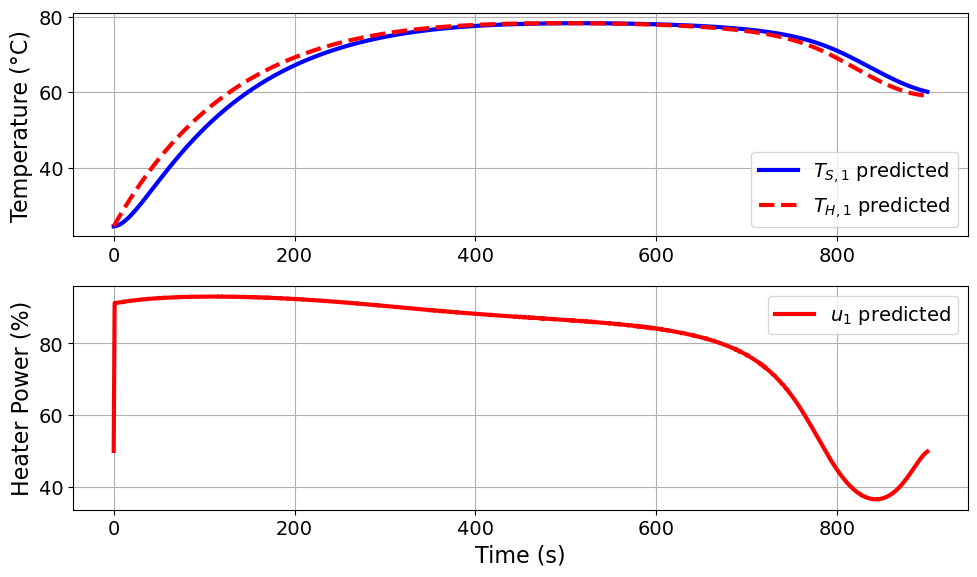

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
 


In [16]:
aopt_pyomo_doe_results = extract_plot_results(None, optimize_result3.model)

Interestingly, we get a different optimal experiment. The A-optimal experiment starts with a ramp around 90\% power. Around 700 seconds, the power is signigicantly reduced, resulting in slight cooling.

In [17]:
optimize_result3.result_analysis()
results_summary(optimize_result3)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.69904706065488
D-optimality: 27.18858455834762
E-optimality: 3.5371505560285486
Modified E-optimality: 6.14572713071946

FIM:
 [[ 1.89991601e+08 -1.91393319e+08 -8.37777345e+06 -7.01417940e+02]
 [-1.91393319e+08  4.80931433e+09  6.51835652e+07  2.98584987e+04]
 [-8.37777345e+06  6.51835652e+07  1.57722375e+06  1.82177349e+04]
 [-7.01417940e+02  2.98584987e+04  1.82177349e+04  4.07195806e+03]]

eigenvalues:
 [4.81812083e+09 1.82252585e+08 5.10367039e+05 3.44469327e+03]

eigenvectors:
 [[ 4.13397884e-02  9.98639527e-01  3.17626753e-02 -1.11744386e-03]
 [-9.99052686e-01  4.17477808e-02 -1.22748394e-02  4.25749195e-04]
 [-1.35923510e-02 -3.12444734e-02  9.98800998e-01 -3.51510621e-02]
 [-6.24867208e-06 -1.26975821e-07  3.51713956e-02  9.99381295e-01]]


## Sensitivity Analysis

The eigendecomposition of the FIM above shows we have the least information (and thus greatest uncertainty) about parameter $C_p^S$. In fact, notice that $C_p^S$ goes to its bound in our earlier [parameter estimation](./parmest.ipynb) analysis.

This uncertainty motivates performing a sensivitiy analysis of the optimal experiment design to perturbations in $C_p^S$. The code below focuses on A-optimality because it is computational less expensive, but and can easily adapted to D-optimality by changing the `objective_option`.

In [18]:
import numpy as np

CpS_values = np.array([0.01, 0.05, 0.1, 0.5, 1.0])
a_opt = np.zeros((len(CpS_values)))
u_solutions = np.zeros((len(CpS_values), len(tc_data.time)))
Ts_solutions = np.zeros((len(CpS_values), len(tc_data.time)))

for i, v in enumerate(CpS_values):

    print("\n********************\nCpS = ", v, " J/°C")

    theta_values_new = theta_values.copy()
    theta_values_new['inv_CpS'] = 1 / v

    # Create a new DoE object
    doe_object = DesignOfExperiments(
        theta_values_new,  # dictionary of parameters
        decisions,  # design variable
        measurements,  # measurement variable
        create_model_doe,  # model
        solver=solver,
        prior_FIM=prior,  # use previous experiment as prior
    )

    # Compute FIM at initial point
    result = doe_object.compute_FIM(
        mode='sequential_finite',
        formula='central',
        tee_opt=False,  # toggle off display to keep notebook shorter
    )

    # Extract the prior FIM and Jacobian information from the previous
    # result to use for initialization.
    jac_for_initialization = result.jaco_information.copy()

    # Solve the DoE problem
    square_result, optimize_result = doe_object.stochastic_program(
        if_optimize=True,  # optimize
        scale_nominal_param_value=True,  # scale model parameter value
        objective_option="trace",  # objective option
        jac_initial=jac_for_initialization,  # initialize Jacobian with prior solution
        step=0.01,  # step size
        tee_opt=False,  # toggle off display to keep notebook shorter
    )

    pyomo_results = extract_results(optimize_result.model)

    results_summary(optimize_result)

    a_opt[i] = np.log10(optimize_result.trace)
    u_solutions[i, :] = pyomo_results.u1
    Ts_solutions[i, :] = pyomo_results.TS1_data

    print("********************\n")


********************
CpS =  0.01  J/°C
INFO: elapsed time: 7.9 seconds
INFO: elapsed time: 16.4 seconds
======Results Summary======
Four design criteria log10() value:
A-optimality: 9.699047060654987
D-optimality: 27.18858453937762
E-optimality: 3.5371505370099876
Modified E-optimality: 6.145727149738004

FIM:
 [[ 1.89991601e+08 -1.91393319e+08 -8.37777345e+06 -7.01417839e+02]
 [-1.91393319e+08  4.80931433e+09  6.51835652e+07  2.98584985e+04]
 [-8.37777345e+06  6.51835652e+07  1.57722375e+06  1.82177345e+04]
 [-7.01417839e+02  2.98584985e+04  1.82177345e+04  4.07195788e+03]]

eigenvalues:
 [4.81812083e+09 1.82252585e+08 5.10367039e+05 3.44469311e+03]

eigenvectors:
 [[ 4.13397884e-02  9.98639527e-01  3.17626753e-02 -1.11744384e-03]
 [-9.99052686e-01  4.17477808e-02 -1.22748394e-02  4.25749184e-04]
 [-1.35923510e-02 -3.12444734e-02  9.98800998e-01 -3.51510612e-02]
 [-6.24867204e-06 -1.26975237e-07  3.51713948e-02  9.99381295e-01]]
********************


********************
CpS =  0.05

Now let's visualize how the *A-optimality objective* changes as a function of $C_p^S$.

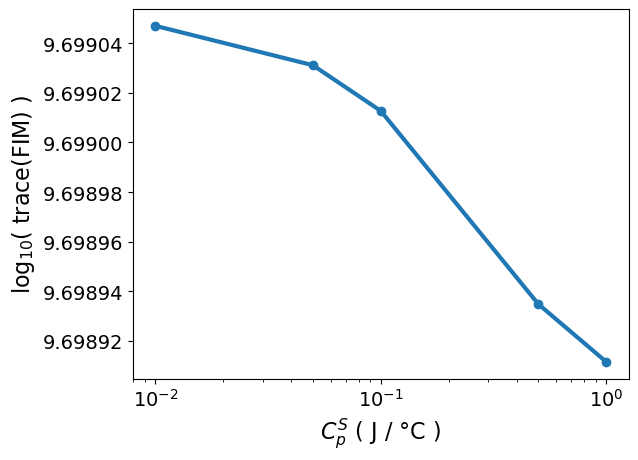

In [19]:
import matplotlib.pyplot as plt

plt.semilogx(CpS_values, a_opt, marker='o')
plt.xlabel('$C_p^S$ ( J / °C )')
plt.ylabel('log$_{10}$( trace(FIM) )')
plt.show()

We see the objective changes insignificantly as we vary $C_p^S$. What about the optimal solution?

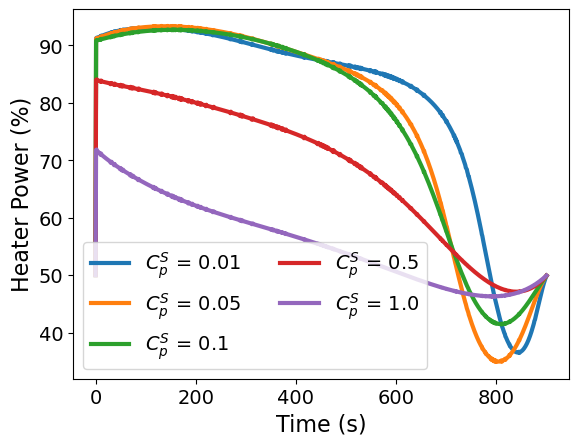

In [20]:
for i, v in enumerate(CpS_values):
    plt.plot(tc_data.time, u_solutions[i, :], label=f'$C_p^S$ = {v}')
plt.legend(ncol=2, loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Heater Power (%)')
plt.show()

Interesting, the A-optimal next experiment does change on the assumed value of $C_p^S$. For small values of $C_p^S$, the optimal solutions are similar: start around $u_1 = 90$% and then decreases as the experiment progresses. As $C_p^S$ increases, the starting value of $u_1$ decreases.

Let's also look at the optimal sensor temperature profile:

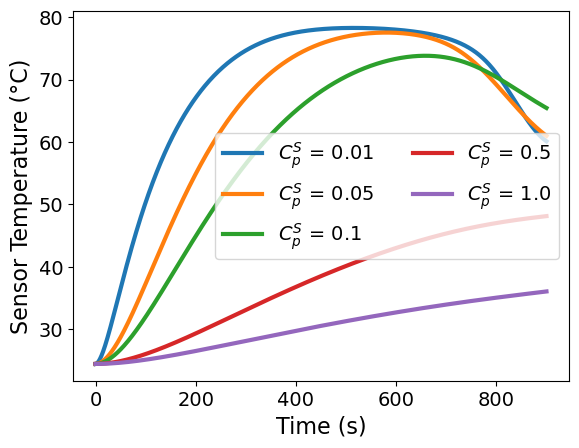

In [21]:
for i, v in enumerate(CpS_values):
    plt.plot(tc_data.time, Ts_solutions[i, :], label=f'$C_p^S$ = {v}')
plt.legend(ncol=2, loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Sensor Temperature (°C)')
plt.show()

Now to be pragmatic. What should we do with this information? Here are some suggested next steps:
- Confirm that these optimal experiments are all very informative for all of the values of $C_p^S$. If this is the case, we can pick on, perform the experiment, and then refit our model.
- Explore alternate formulations of MBDoE that consider uncertainty. We are working on a major overhaul of Pyomo.DoE that will make this much easier.